Дано:
2 датафрейма с постами и соответствующими юзерами, поставивших реакции

Оставляем только релевантных юзеров

In [1]:
import pandas as pd
import numpy as np
import json
from wordcloud import WordCloud

import matplotlib.pyplot as plt

In [2]:
df_1 = pd.read_json('datasets/nastavnichestvo_it_final.json', orient='index')
df_2 = pd.read_json('datasets/prepodavanie_it_final.json', orient='index')
df_3 = pd.read_json('datasets/mentor_it_posts.json', orient='index')

In [3]:
df = pd.concat([df_1,df_2, df_3]).reset_index(drop=True)
df

,0,1
0,Будет ли еще мой менторский курс по IT Рекрутм...,{'https://www.linkedin.com/in/ACoAABdk1nkBsBNQ...
1,Всем привет - Нахожусь в поиске работы по спец...,{'https://www.linkedin.com/in/ACoAAAHO6ccBTyhb...
2,Ищем к себе в команду Системного аналитика.Как...,{'https://www.linkedin.com/in/ACoAADIb9yEBkqOP...
3,08.08.22 - 1й день с командой IT_One.Долгождан...,{'https://www.linkedin.com/in/ACoAADlYxTkBWDm_...
4,Как менторам развивать Data Science сообщество...,{'https://www.linkedin.com/in/ACoAADe6becBwuAU...
...,...,...
491,Ние от Фондация Предай Нататък сме безкрайно б...,{'https://www.linkedin.com/in/ACoAAAQTf7oBjOcB...
492,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAAD5pfkUBtWX3...
493,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzyGWUBd59E...
494,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzB48MBmH69...


In [4]:
df[1][0]

{'https://www.linkedin.com/in/ACoAABdk1nkBsBNQnzJyN8ucY8AO8s4Ex33CWuM': ['Leila Rajapova',
  'IT recruiter'],
 'https://www.linkedin.com/in/ACoAADcbdQIBouDEG4rTsxN3e3AWQDGpzt3neL4': ['Анастасия Прохорова',
  'IT recruiter 🔍'],
 'https://www.linkedin.com/in/ACoAADCkYMwB61VZ3NyE77IGOx0XAlJZrM_bN1Y': ['Bekzod Khabibullaev',
  'Business Management'],
 'https://www.linkedin.com/in/ACoAADskSvUBmr0u-Je9eX1CLhHXqtzilIB4j74': ['Dmitry Drobov',
  'QA Engineer with 1+ year experience | Web | Mobile | Blockchain'],
 'https://www.linkedin.com/in/ACoAABSNNvYBouwqj96_Ju9wOZJJIESC2fGNnfs': ['Дмитрий Каулькин',
  '--'],
 'https://www.linkedin.com/in/ACoAAEBECeoBJiCXX92eHtohZaGwUfzrZjuBs4c': ['Ekaterina Milichkina',
  'IT Recruiter'],
 'https://www.linkedin.com/in/ACoAAA69QbcBdsk4vJLyM1Jzjjn_tY3IJROS2PQ': ['Mark Beseliya',
  'Project Manager Product Manager 8+ years | IT international vendors | SMB companies'],
 'https://www.linkedin.com/in/ACoAADyOO1oBOYhzQeCziPm25XNSIOXFOnVdwY0': ['Anastasia Khutornay

В идеале нам нужно сходить на линк каждого юзера, отреагировавшего на пост, но алгоритмы Linkedin'а нас быстро забанят. Поэтому будем работать с тем, что есть

In [5]:
df.columns = ['post_text','reacted_users_info']
df

,post_text,reacted_users_info
0,Будет ли еще мой менторский курс по IT Рекрутм...,{'https://www.linkedin.com/in/ACoAABdk1nkBsBNQ...
1,Всем привет - Нахожусь в поиске работы по спец...,{'https://www.linkedin.com/in/ACoAAAHO6ccBTyhb...
2,Ищем к себе в команду Системного аналитика.Как...,{'https://www.linkedin.com/in/ACoAADIb9yEBkqOP...
3,08.08.22 - 1й день с командой IT_One.Долгождан...,{'https://www.linkedin.com/in/ACoAADlYxTkBWDm_...
4,Как менторам развивать Data Science сообщество...,{'https://www.linkedin.com/in/ACoAADe6becBwuAU...
...,...,...
491,Ние от Фондация Предай Нататък сме безкрайно б...,{'https://www.linkedin.com/in/ACoAAAQTf7oBjOcB...
492,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAAD5pfkUBtWX3...
493,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzyGWUBd59E...
494,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzB48MBmH69...


У нас нет большого размеченного датасета чтобы сделать ML-модель определяющую насколько тот или иной юзер для нас релевантен. Поэтому будем визуализировать "облако названий профессий" и убирать из них не-it и около-it специальности.

Оставим профессии со словами `middle`, `senior`, `lead` и исключим нерелевантные специальности

In [6]:
# def relevant_job_title_extraction(reactions_info):
#     '''функция фильтрует профессии и оставляет только те, которые соответствуют релевантному паттерну'''
#     relevant_list = ['senior', 'middle','lead']
#     not_relevant_list = ['hr','recruiter','manager','looking','consultant','seo','консультант', 'management']
#     job_titles = []
#     for user_info in reactions_info.values():
#         true_pattern = [x in user_info[1].lower() for x in relevant_list]
#         wrong_pattern = [x in user_info[1].lower() for x in not_relevant_list]
#         pattern = any(true_pattern) and not any(wrong_pattern)
#         if pattern:
#             job_titles.append(user_info[1])
#     job_titles = ' '.join(job_titles)
#     return job_titles

In [7]:
def relevant_users_extraction(reactions_info):
    '''функция фильтрует профессии и оставляет только те, которые соответствуют релевантному паттерну'''
    relevant_list = ['senior', 'middle','lead']
    not_relevant_list = ['hr','recruiter','manager','looking','consultant','seo','консультант', 'management']
    relevant = {}
    job_titles = []
    for link, user_info in reactions_info.items():
        true_pattern = [x in user_info[1].lower() for x in relevant_list]
        wrong_pattern = [x in user_info[1].lower() for x in not_relevant_list]
        pattern = any(true_pattern) and not any(wrong_pattern)
        if pattern:
            relevant[link] = user_info
            job_titles.append(user_info[1])
    job_titles = ' '.join(job_titles)
    return relevant, job_titles

In [8]:
df['relevant_users_info'], df['relevant_users_jobs'] = zip(*df.reacted_users_info.apply(relevant_users_extraction))
df['relevant_reactions_count'] = df.relevant_users_info.apply(len)
df

,post_text,reacted_users_info,relevant_users_info,relevant_users_jobs,relevant_reactions_count
0,Будет ли еще мой менторский курс по IT Рекрутм...,{'https://www.linkedin.com/in/ACoAABdk1nkBsBNQ...,{'https://www.linkedin.com/in/ACoAAAsta0oB-7DI...,"Senior DevOps, Python, Go, Terraform, AWS Seni...",3
1,Всем привет - Нахожусь в поиске работы по спец...,{'https://www.linkedin.com/in/ACoAAAHO6ccBTyhb...,{},,0
2,Ищем к себе в команду Системного аналитика.Как...,{'https://www.linkedin.com/in/ACoAADIb9yEBkqOP...,{},,0
3,08.08.22 - 1й день с командой IT_One.Долгождан...,{'https://www.linkedin.com/in/ACoAADlYxTkBWDm_...,{'https://www.linkedin.com/in/ACoAAA9mS0oBk9SB...,Employer brand Lead Lead System Administrator ...,10
4,Как менторам развивать Data Science сообщество...,{'https://www.linkedin.com/in/ACoAADe6becBwuAU...,{'https://www.linkedin.com/in/ACoAAA_jgFoBhpoZ...,Machine Learning Researcher | Academic Leader ...,1
...,...,...,...,...,...
491,Ние от Фондация Предай Нататък сме безкрайно б...,{'https://www.linkedin.com/in/ACoAAAQTf7oBjOcB...,{'https://www.linkedin.com/in/ACoAAAQ3L2UB-T_o...,Human Resources Director Commercial & Human Re...,2
492,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAAD5pfkUBtWX3...,{'https://www.linkedin.com/in/ACoAABOROhIBtXPX...,Senior Quality Assurance Engineer Input Valida...,18
493,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzyGWUBd59E...,{'https://www.linkedin.com/in/ACoAAC4jAwUBXkJm...,Senior Sales and Customer Advisor SMM Team Lea...,5
494,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzB48MBmH69...,{'https://www.linkedin.com/in/ACoAADgEp5oBt9oU...,Input Validation Senior Data Processor Senior ...,2


In [9]:
wc = WordCloud(background_color="white", font_path="./arial.ttf", width=1600, height=800, max_words=1000)
wc.generate(' '.join(df.relevant_users_jobs))

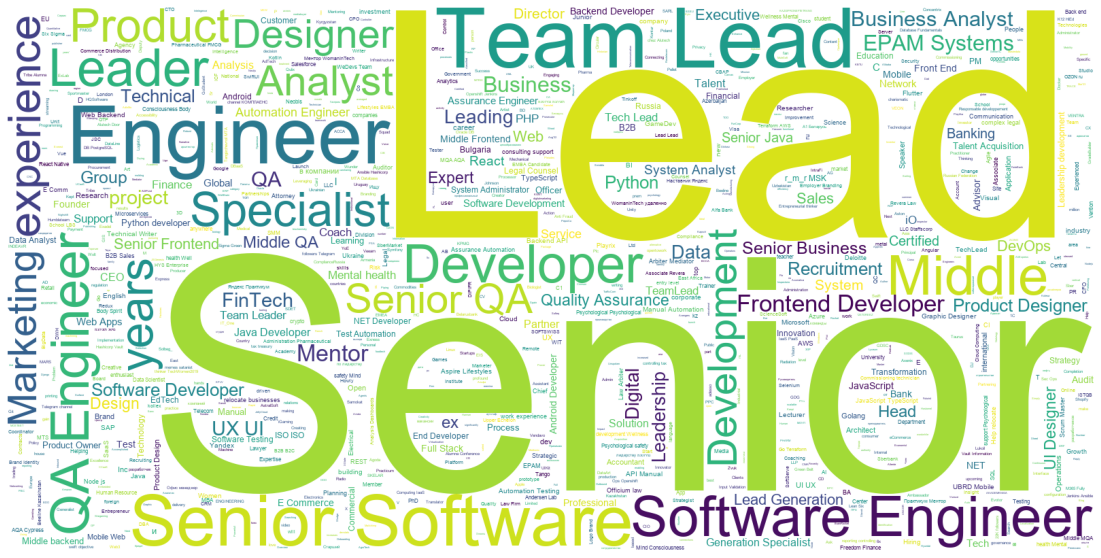

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

Остались только релевантные профессии. Удалим полные дубликаты постов

In [11]:
df.drop('relevant_users_jobs', axis=1, inplace=True)
df.drop_duplicates('post_text', inplace=True)
df

,post_text,reacted_users_info,relevant_users_info,relevant_reactions_count
0,Будет ли еще мой менторский курс по IT Рекрутм...,{'https://www.linkedin.com/in/ACoAABdk1nkBsBNQ...,{'https://www.linkedin.com/in/ACoAAAsta0oB-7DI...,3
1,Всем привет - Нахожусь в поиске работы по спец...,{'https://www.linkedin.com/in/ACoAAAHO6ccBTyhb...,{},0
2,Ищем к себе в команду Системного аналитика.Как...,{'https://www.linkedin.com/in/ACoAADIb9yEBkqOP...,{},0
3,08.08.22 - 1й день с командой IT_One.Долгождан...,{'https://www.linkedin.com/in/ACoAADlYxTkBWDm_...,{'https://www.linkedin.com/in/ACoAAA9mS0oBk9SB...,10
4,Как менторам развивать Data Science сообщество...,{'https://www.linkedin.com/in/ACoAADe6becBwuAU...,{'https://www.linkedin.com/in/ACoAAA_jgFoBhpoZ...,1
...,...,...,...,...
490,🎓 Уште една група од Академијата за дигитален ...,{'https://www.linkedin.com/in/ACoAACeKUC8BcJYp...,{},0
491,Ние от Фондация Предай Нататък сме безкрайно б...,{'https://www.linkedin.com/in/ACoAAAQTf7oBjOcB...,{'https://www.linkedin.com/in/ACoAAAQ3L2UB-T_o...,2
492,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAAD5pfkUBtWX3...,{'https://www.linkedin.com/in/ACoAABOROhIBtXPX...,18
493,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzyGWUBd59E...,{'https://www.linkedin.com/in/ACoAAC4jAwUBXkJm...,5


In [12]:
df.to_csv('datasets/filtered_posts_df.csv', index=False)

In [13]:
pd.read_csv('datasets/filtered_posts_df.csv')

,post_text,reacted_users_info,relevant_users_info,relevant_reactions_count
0,Будет ли еще мой менторский курс по IT Рекрутм...,{'https://www.linkedin.com/in/ACoAABdk1nkBsBNQ...,{'https://www.linkedin.com/in/ACoAAAsta0oB-7DI...,3
1,Всем привет - Нахожусь в поиске работы по спец...,{'https://www.linkedin.com/in/ACoAAAHO6ccBTyhb...,{},0
2,Ищем к себе в команду Системного аналитика.Как...,{'https://www.linkedin.com/in/ACoAADIb9yEBkqOP...,{},0
3,08.08.22 - 1й день с командой IT_One.Долгождан...,{'https://www.linkedin.com/in/ACoAADlYxTkBWDm_...,{'https://www.linkedin.com/in/ACoAAA9mS0oBk9SB...,10
4,Как менторам развивать Data Science сообщество...,{'https://www.linkedin.com/in/ACoAADe6becBwuAU...,{'https://www.linkedin.com/in/ACoAAA_jgFoBhpoZ...,1
...,...,...,...,...
479,🎓 Уште една група од Академијата за дигитален ...,{'https://www.linkedin.com/in/ACoAACeKUC8BcJYp...,{},0
480,Ние от Фондация Предай Нататък сме безкрайно б...,{'https://www.linkedin.com/in/ACoAAAQTf7oBjOcB...,{'https://www.linkedin.com/in/ACoAAAQ3L2UB-T_o...,2
481,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAAD5pfkUBtWX3...,{'https://www.linkedin.com/in/ACoAABOROhIBtXPX...,18
482,През изминалата седмица един от нашите основат...,{'https://www.linkedin.com/in/ACoAADzyGWUBd59E...,{'https://www.linkedin.com/in/ACoAAC4jAwUBXkJm...,5
